<a href="https://colab.research.google.com/github/jnrkufuor/apollo/blob/Ernest/notebooks/Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Load Packagaes

In [1]:
!pip install squarify

import pandas as pd
import numpy as np
import math
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import statistics
#from google.colab import drive
#drive.mount('/content/drive')

tqdm.pandas()

C:\Users\jaycu\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


#2. Load data

##2.1 Load News Data

In [2]:
#df_articles =  pd.read_csv('/content/drive/My Drive/Colab Notebooks/googlenews1000.csv')

#df_links = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_links_att2.csv')
df_links = pd.read_csv('../data/df_links_2011_2015.csv')
print(len(df_links.index))

#hyperparamaters
weight_criteria = 6

1591


##2.2 Load Financial data

In [3]:
#df_prices =  pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/price_corr.csv')
#df_vol =  pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/volume_corr.csv')

df_prices =  pd.read_csv('../data/price_corr.csv')
df_vol =  pd.read_csv('../data/volume_corr.csv')

df_finance_nds = pd.DataFrame(columns = ["from", "to", "weight"])

df_prices = df_prices.drop(df_prices.columns[0], axis=1)
df_prices.index = df_prices.columns

df_vol = df_vol.drop(df_vol.columns[0], axis=1)
df_vol.index = df_vol.columns

##2.3 Find Unique Pairs from Correlation Coefficient

In [4]:
# Get correlation pairs for Price and Volume
df_corr_price = df_prices[abs(df_prices) >= 0.0001].stack().reset_index()
df_corr_vol = df_vol[abs(df_vol) >= 0.0001].stack().reset_index()

#Take out lower triangle 
#for price
df_corr_price  = df_corr_price[df_corr_price['level_0'].astype(str)!=df_corr_price['level_1'].astype(str)]
df_corr_price['ordered-cols'] = df_corr_price.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)

#for volume
df_corr_vol  = df_corr_vol[df_corr_vol['level_0'].astype(str)!=df_corr_vol['level_1'].astype(str)]
df_corr_vol['ordered-cols'] = df_corr_vol.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)

#Remove duplicates and exclude self-correlated values
#for price
df_corr_price = df_corr_price.drop_duplicates(['ordered-cols'])
df_corr_price.reset_index(drop=True, inplace=True)
df_corr_price.drop(['ordered-cols'], axis=1, inplace=True)

#for volume
df_corr_vol = df_corr_vol.drop_duplicates(['ordered-cols'])
df_corr_vol.reset_index(drop=True, inplace=True)
df_corr_vol.drop(['ordered-cols'], axis=1, inplace=True)

#rename columns
df_corr_price.columns = ["from","to","correlation"]
df_corr_vol.columns = ["from","to","correlation"]

#3. Subset data

In [5]:
#Subset mews data. Count all links and store under weight column
df_links = df_links.groupby(['from', 'to']).size().reset_index()
df_links.rename(columns={0: 'weight'}, inplace=True)
df_links.reset_index(drop=True, inplace=True)

In [6]:
#normalize values and create co-mention matrix
#df_links['weight'] =(df_links['weight']-df_links['weight'].min())/(df_links['weight'].max()-df_links['weight'].min())
df_links = df_links[df_links['weight'] > weight_criteria]

In [7]:
df_links[['from', 'to', 'weight']].sort_values('weight', ascending=False).tail(10)

,from,to,weight
47,AXP,GS,8
329,NKE,V,8
198,GS,V,7
219,IBM,JNJ,7
221,IBM,KO,7
146,CVX,MSFT,7
234,INTC,JPM,7
135,CVX,DOW,7
244,INTC,VZ,7
2,AAPL,BA,7


##3.2 Subset Financial Nodes

In [8]:
#fi
for i in range(1,len(df_corr_price)):
    if(abs(df_corr_price["correlation"][i]) > 0.8 or abs(df_corr_vol["correlation"][i]) > 0.8):
       df_finance_nds= df_finance_nds.append({"from" : df_corr_vol["from"][i], "to" : df_corr_vol["to"][i], "weight" : ((abs(df_corr_price["correlation"][i])+abs(df_corr_price["correlation"][i]))/2)},ignore_index=True)
    elif (abs(df_corr_price["correlation"][i]) < 0.8 and abs(df_corr_vol["correlation"][i]) < 0.8):
         if (abs(df_corr_price["correlation"][i]) >= 0.5 and abs(df_corr_vol["correlation"][i]) >= 0.5):
             df_finance_nds = df_finance_nds.append({"from" : df_corr_vol["from"][i], "to" : df_corr_vol["to"][i], "weight" : ((abs(df_corr_price["correlation"][i])+abs(df_corr_price["correlation"][i]))/2)},ignore_index=True)
df_finance_nds.head(10)


,from,to,weight
0,AXP,CAT,0.548812
1,AXP,CVX,0.510701
2,AXP,GS,0.653400
3,AXP,HD,0.519912
4,AXP,JPM,0.710496
5,AXP,TRV,0.559720
6,CAT,JPM,0.528654
7,CSCO,MSFT,0.567961
8,GS,JPM,0.721061
9,GS,TRV,0.506627


#4. Plot Edges

In [143]:
#create plot variables

#for news
df_plot_news = df_links
df_plot_news.reset_index(inplace=True, drop=True)

#for finance
df_plot_fin = df_finance_nds
df_plot_fin.reset_index(inplace=True, drop=True)

#Build Graph Variables
G = nx.Graph() #news graph
G2 = nx.Graph() #finacial graph

#add edges and nodes to graph

#for news
for link in tqdm(df_plot_news.index):
  G.add_edge(df_plot_news.iloc[link]['from'],
             df_plot_news.iloc[link]['to'],
             weight=df_plot_news.iloc[link]['weight'])

#for financial
for link in tqdm(df_plot_fin.index):
  G2.add_edge(df_plot_fin.iloc[link]['from'],
             df_plot_fin.iloc[link]['to'],
             weight=df_plot_fin.iloc[link]['weight'])

100%|██████████| 14/14 [00:00<00:00, 1166.38it/s]


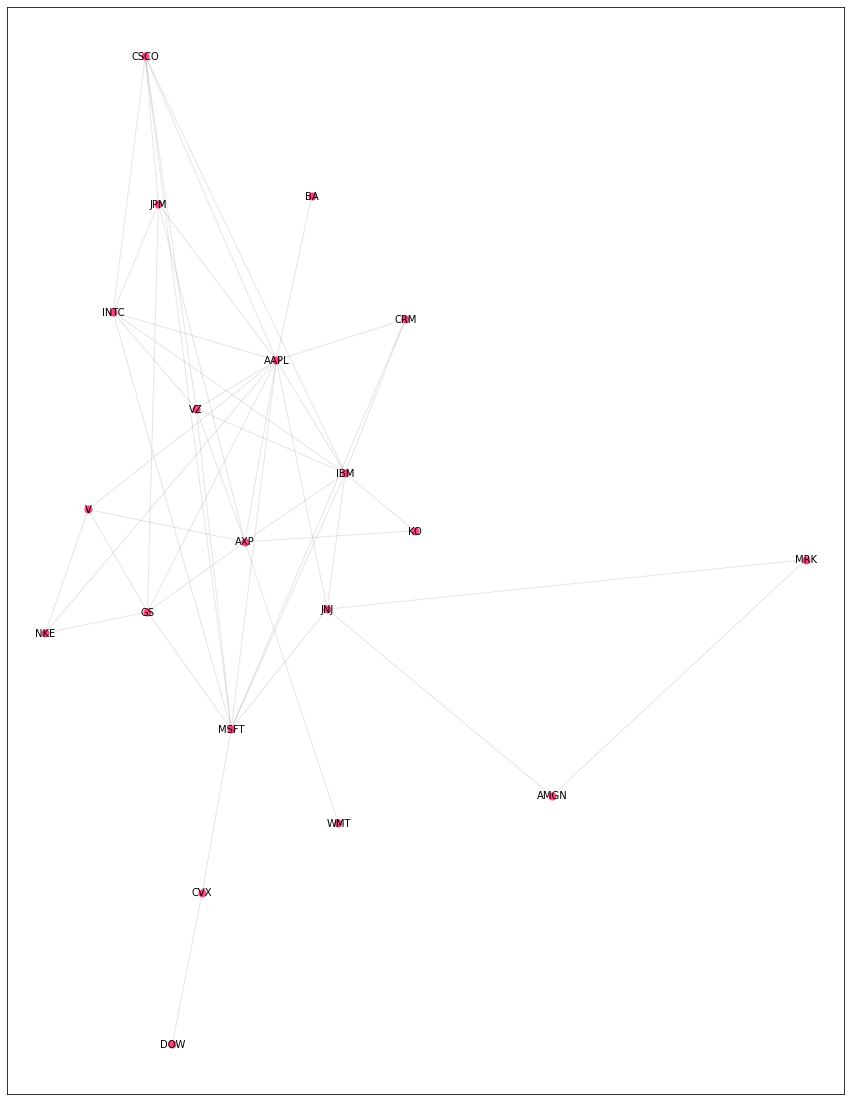

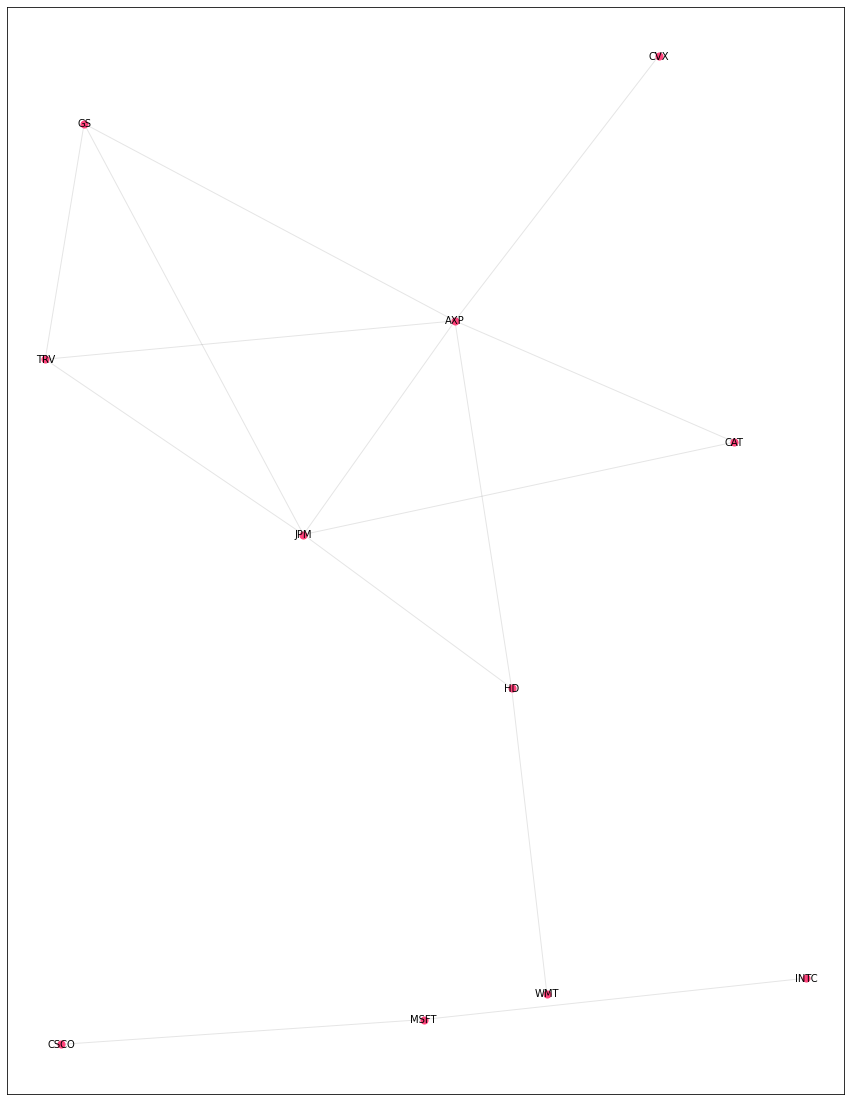

In [144]:
graph = G
for i in range(2):
    pos = nx.kamada_kawai_layout(graph)
    nodes = graph.nodes()
    fig, axs = plt.subplots(1, 1, figsize=(15,20))

    el = nx.draw_networkx_edges(graph, pos, alpha=0.1, ax=axs)
    nl = nx.draw_networkx_nodes(graph, pos, nodelist=nodes, node_color='#FF427b', 
                                node_size=50, ax=axs)
    ll = nx.draw_networkx_labels(graph, pos, font_size=10, font_family='sans-serif')
    
    graph = G2

#5. Find Subgraphs

Build NetworkX graph


In [120]:
df_link = df_links
df_link.reset_index(inplace=True, drop=True)

G = nx.Graph()

for link in tqdm(df_link.index):
  G.add_edge(df_link.iloc[link]['from'],
             df_link.iloc[link]['to'],
             weight=df_link.iloc[link]['weight'])

100%|██████████| 28/28 [00:00<00:00, 1170.46it/s]


Find Centralities

100%|██████████| 16/16 [00:00<00:00, 16070.13it/s]


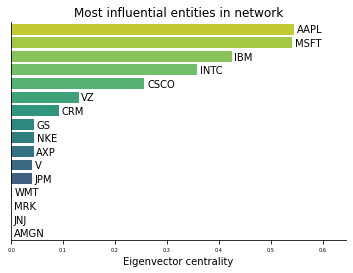

In [121]:
nodes = []
eigenvector_cents = []
ec_dict = nx.eigenvector_centrality(G, max_iter=1000, weight='weight')

for node in tqdm(G.nodes()):
  nodes.append(node)
  eigenvector_cents.append(ec_dict[node])

df_centralities = pd.DataFrame(data={'entity': nodes,
                                     'eigenvector': eigenvector_cents})

df_cent_top = df_centralities.sort_values('eigenvector', ascending=False).head(20)
df_cent_top.reset_index(inplace=True, drop=True)

g = sns.barplot(data=df_cent_top,
            x='eigenvector',
            y='entity',
            dodge=False,
            orient='h',
            hue='eigenvector',
            palette='viridis',)

g.set_yticks([])
g.set_title('Most influential entities in network')
g.set_xlabel('Eigenvector centrality')
g.set_ylabel('')
g.set_xlim(0, max(df_cent_top['eigenvector'])+0.1)
g.legend_.remove()
g.tick_params(labelsize=5)

for i in df_cent_top.index:
    g.text(df_cent_top.iloc[i]['eigenvector']+0.005, i+0.25, df_cent_top.iloc[i]['entity'])

sns.despine()
g.get_figure().savefig('cent_plot.png', dpi=1000)

#6. Cliques

Finding the optimal number


In [122]:
from networkx.algorithms.community.kclique import k_clique_communities

100%|██████████| 28/28 [00:00<00:00, 4009.58it/s]


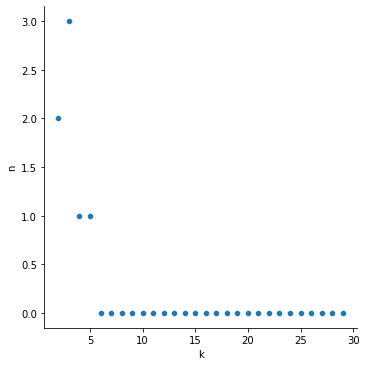

In [123]:
clique_sizes = range(2, 30)
n_cliques = []
0
for k in tqdm(clique_sizes):
  n_cliques.append(len(list(k_clique_communities(G, k))))

df_relplot = pd.DataFrame(data={'k': clique_sizes,
                                'n': n_cliques})

sns.relplot(data=df_relplot,
            x='k',
            y='n')

In [124]:
cliques = list(k_clique_communities(G, 2))

Find centralities in cliques

In [125]:
eigenvector_cents = []
entities = []
clique_ids = []

for id, clique in enumerate(cliques):
  sg = G.subgraph(list(clique))

  nodes = sg.nodes()

  clique_ids.extend(np.repeat(id, len(nodes)))
  entities.extend(nodes)

  ec_dict = nx.eigenvector_centrality(sg, max_iter=1000, weight='weight')

  for entity in nodes:
    eigenvector_cents.append(ec_dict[entity])

df_cliques = pd.DataFrame(data={
    'clique': clique_ids,
    'entity': entities,
    'centrality': eigenvector_cents
})

df_cliques

,clique,entity,centrality
0,0,AAPL,0.545080
1,0,CSCO,0.256851
2,0,GS,0.044538
3,0,IBM,0.425044
4,0,INTC,0.358387
5,0,JPM,0.039404
6,0,MSFT,0.541626
7,0,NKE,0.044289
8,0,V,0.040980
9,0,VZ,0.130061


In [126]:
col_pal = {0: '#F1E3F3',
           1: '#A0DDFF',
           2: '#FF8A5B',
           3: '#74D3AE',
           4: '#93B7BE',
           5: '#D1B1CB',
           6: '#BAF2BB',
           7: '#FFA69E',
           8: '#97EAD2',
           9: '#34E4EA',
           10: '#B95F89',
           99:'#828A95'}

Plot Cliques

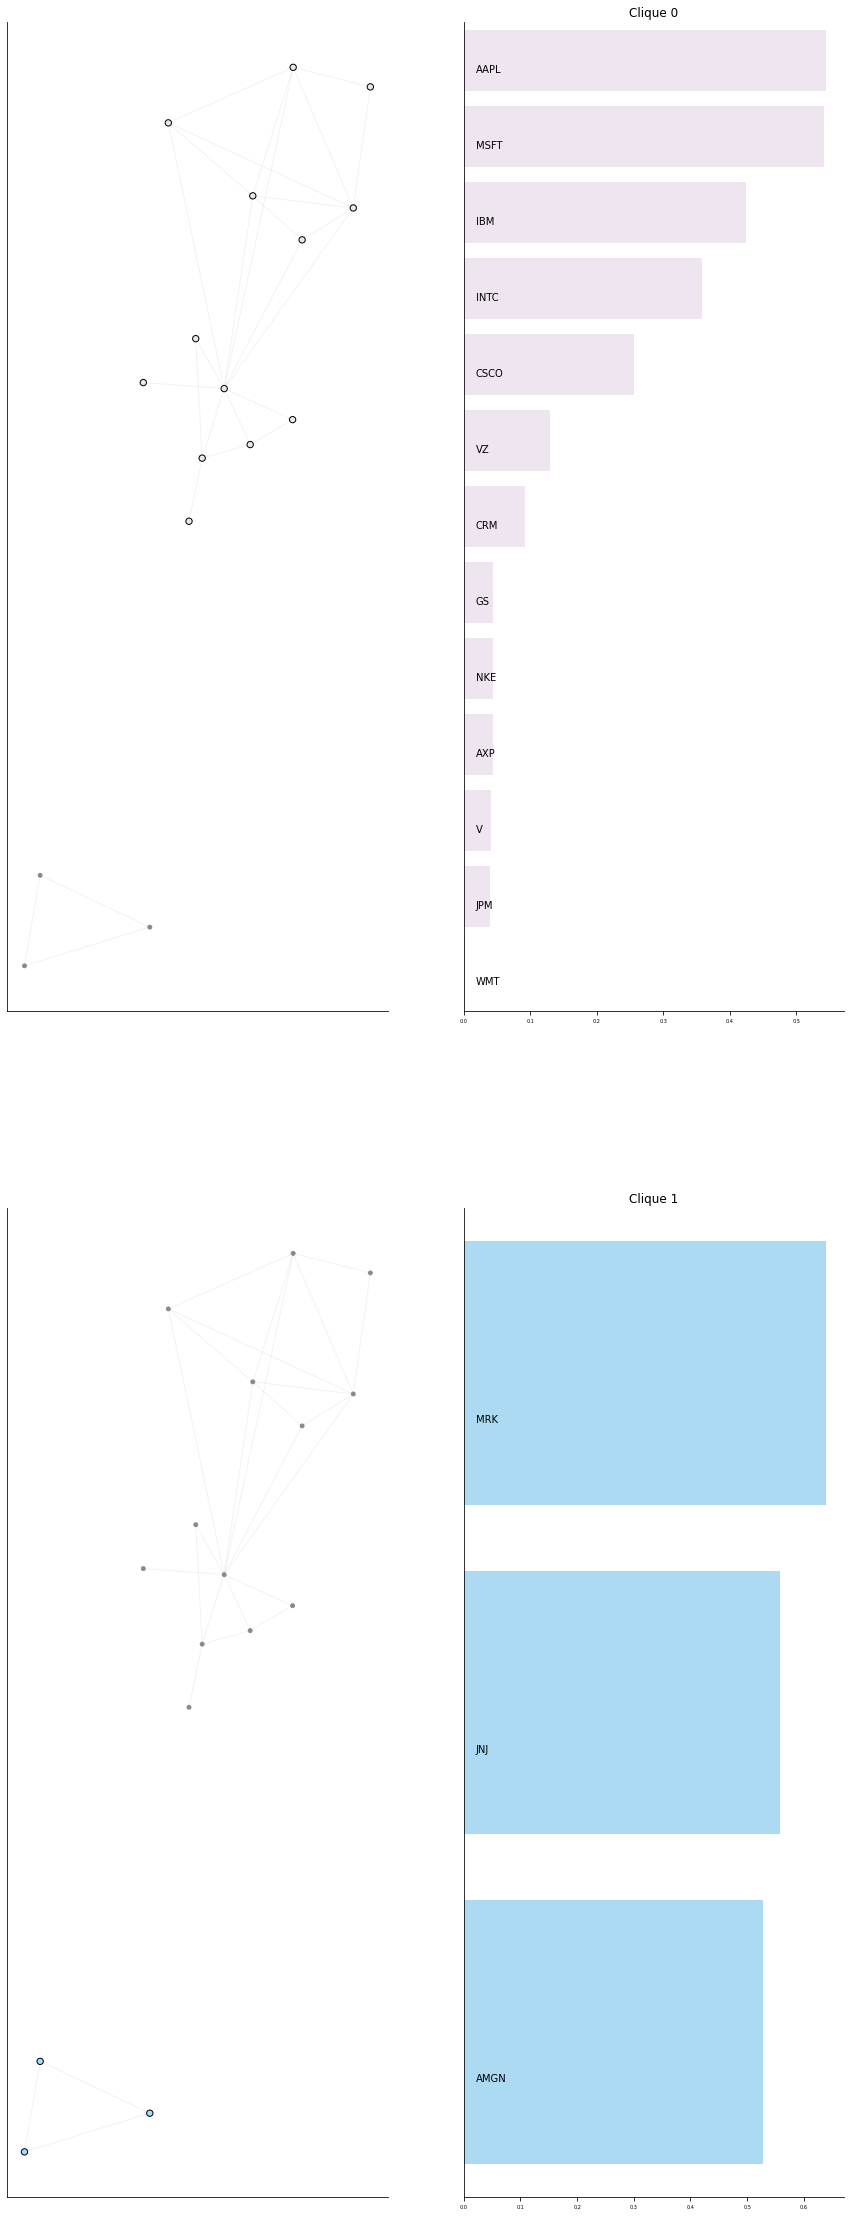

In [127]:
G_clique = G.subgraph(df_cliques['entity'].unique())
pos = nx.kamada_kawai_layout(G_clique)
nodes = G_clique.nodes()


fig, axs = plt.subplots(max(df_cliques['clique'])+1, 2, figsize=(15,40))

for clique in range(max(df_cliques['clique'])+1):
  node_colors = [col_pal[clique] if node in df_cliques[df_cliques['clique']==clique]['entity'].values else col_pal[99] for node in nodes]
  sizes = [40 if node in df_cliques[df_cliques['clique']==clique]['entity'].values else 15 for node in nodes]
  edge_colors = ['black' if node in df_cliques[df_cliques['clique']==clique]['entity'].values else col_pal[99] for node in nodes]

  ec = nx.draw_networkx_edges(G_clique, pos, alpha=0.05, ax=axs[clique, 0])
  nc = nx.draw_networkx_nodes(G_clique, pos, nodelist=nodes, node_color=node_colors, 
                              node_size=sizes, ax=axs[clique, 0],
                              edgecolors=edge_colors)
  
  df_clique_ind = df_cliques[df_cliques['clique']==clique]
  df_clique_ind = df_clique_ind.sort_values('centrality', ascending=False).head(15)
  df_clique_ind.reset_index(inplace=True, drop=True)

  g = sns.barplot(data=df_clique_ind,
              x='centrality',
              y='entity',
              hue='clique',
              palette=col_pal,
              dodge=False,
              orient='h',
              ax=axs[clique, 1])
  
  g.set_yticks([])
  g.set_title(f'Clique {clique}')
  g.set_xlabel('')
  g.set_ylabel('')
  g.legend_.remove()
  g.tick_params(labelsize=5)

  for i in df_clique_ind.index:
    g.text(max(df_clique_ind['centrality'])/30, i+0.15, df_clique_ind.iloc[i]['entity'])
  

sns.despine()

fig.savefig('clique_plot.png', dpi=1000)

#4 Implement Multiplex Graph

In [145]:
 #install recommended packages
 !pip install deepgraph
 import deepgraph as dg

 

    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\jaycu\anaconda3\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\jaycu\\AppData\\Local\\Temp\\pip-install-vu_yu2hw\\deepgraph\\setup.py'"'"'; __file__='"'"'C:\\Users\\jaycu\\AppData\\Local\\Temp\\pip-install-vu_yu2hw\\deepgraph\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\jaycu\AppData\Local\Temp\pip-pip-egg-info-j7656p4m'
         cwd: C:\Users\jaycu\AppData\Local\Temp\pip-install-vu_yu2hw\deepgraph\
    Complete output (43 lines):
    C:\Users\jaycu\anaconda3\lib\site-packages\numpy\__init__.py:138: UserWarning: mkl-service package failed to import, therefore Intel(R) MKL initialization ensuring its correct out-of-the box operation under condition when Gnu OpenMP had already been loaded by Python process is not assured. P

ModuleNotFoundError: No module named 'deepgraph'